In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [82]:
print("="*60)
print("DECISION TREE - ANALISIS KEAMANAN TRANSPORTASI")
print("="*60)

DECISION TREE - ANALISIS KEAMANAN TRANSPORTASI


In [83]:
# ==========================================
# 1. LOAD DAN PREPROCESSING DATA
# ==========================================


df = pd.read_csv('dataset.csv')

print("1. OVERVIEW DATA")
print("-" * 30)
print(f"Shape dataset: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nSample data:")
df

1. OVERVIEW DATA
------------------------------
Shape dataset: (360, 6)
Columns: ['id_tabel', 'kategori', 'uraian', 'satuan', 'tahun', 'nilai']

Sample data:


,id_tabel,kategori,uraian,satuan,tahun,nilai
0,B.1.12.01,Moda Perkeretaapian,Kecelakaan,Kejadian,2005,11
1,B.1.12.01,Moda Perkeretaapian,Korban Luka-luka,Orang,2005,0
2,B.1.12.01,Moda Perkeretaapian,Korban Meninggal,Orang,2005,0
3,B.1.12.01,Moda Perkeretaapian,Jumlah Laporan Final,Dokumen,2005,0
4,B.1.12.01,Moda Perkeretaapian,Rekomendasi Keselamatan,Rekomendasi,2005,0
...,...,...,...,...,...,...
355,B.1.12.01,Moda LLAJ,Kecelakaan,Kejadian,2022,15
356,B.1.12.01,Moda LLAJ,Korban Luka-luka,Orang,2022,256
357,B.1.12.01,Moda LLAJ,Korban Meninggal,Orang,2022,101
358,B.1.12.01,Moda LLAJ,Jumlah Laporan Final,Dokumen,2022,14


In [84]:
# ==========================================
# 2. EKSPLORASI DATA AWAL
# ==========================================

print("\n2. EKSPLORASI DATA")
print("-" * 30)
print("Unique values per kolom:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

print(f"\nModa transportasi: {df['kategori'].unique()}")
print(f"Periode data: {df['tahun'].min()} - {df['tahun'].max()}")


2. EKSPLORASI DATA
------------------------------
Unique values per kolom:
id_tabel: 1 unique values
kategori: 4 unique values
uraian: 5 unique values
satuan: 4 unique values
tahun: 18 unique values
nilai: 102 unique values

Moda transportasi: ['Moda Perkeretaapian' 'Moda Pelayaran' 'Moda Penerbangan' 'Moda LLAJ']
Periode data: 2005 - 2022


In [85]:
# ==========================================
# 3. DATA PREPROCESSING & FEATURE ENGINEERING
# ==========================================

print("\n3. PREPROCESSING DATA")
print("-" * 30)

# Pivot data untuk mendapatkan struktur yang lebih baik
df_pivot = df.pivot_table(
    index=['tahun', 'kategori'], 
    columns='uraian', 
    values='nilai', 
    aggfunc='first'
).reset_index()

# Flatten column names
df_pivot.columns.name = None
df_pivot.columns = [col.replace(' ', '_').lower() if col not in ['tahun', 'kategori'] else col 
                   for col in df_pivot.columns]

print("Struktur data setelah pivot:")
print(df_pivot.head())
print(f"Shape setelah pivot: {df_pivot.shape}")

# Handle missing values
df_pivot = df_pivot.fillna(0)


3. PREPROCESSING DATA
------------------------------
Struktur data setelah pivot:
   tahun             kategori  jumlah_laporan_final  kecelakaan  \
0   2005            Moda LLAJ                     0           0   
1   2005       Moda Pelayaran                     0           6   
2   2005     Moda Penerbangan                     0          23   
3   2005  Moda Perkeretaapian                     0          11   
4   2006            Moda LLAJ                     0           8   

   korban_luka-luka  korban_meninggal  rekomendasi_keselamatan  
0                 0                 0                        0  
1                 0                 0                        0  
2                 0                 0                        0  
3                 0                 0                        0  
4                 0                 0                        0  
Shape setelah pivot: (72, 7)


In [86]:
# ==========================================
# 4. FEATURE ENGINEERING
# ==========================================

print("\n4. FEATURE ENGINEERING")
print("-" * 30)

# Buat features baru
df_pivot['total_korban'] = df_pivot['korban_luka-luka'] + df_pivot['korban_meninggal']

# Rasio keparahan (severity ratio)
df_pivot['severity_ratio'] = np.where(
    df_pivot['kecelakaan'] > 0,
    (df_pivot['korban_meninggal'] * 3 + df_pivot['korban_luka-luka']) / df_pivot['kecelakaan'],
    0
)

# Rasio korban per kecelakaan
df_pivot['korban_per_kecelakaan'] = np.where(
    df_pivot['kecelakaan'] > 0,
    df_pivot['total_korban'] / df_pivot['kecelakaan'],
    0
)

# Periode kategorikal
df_pivot['periode'] = pd.cut(df_pivot['tahun'], 
                            bins=[2004, 2010, 2016, 2022], 
                            labels=['Early', 'Mid', 'Late'])

print("Features yang dibuat:")
print("- total_korban: Jumlah total korban (luka + meninggal)")
print("- severity_ratio: Rasio keparahan kecelakaan")
print("- korban_per_kecelakaan: Rata-rata korban per kecelakaan")
print("- periode: Kategorisasi periode waktu")


4. FEATURE ENGINEERING
------------------------------
Features yang dibuat:
- total_korban: Jumlah total korban (luka + meninggal)
- severity_ratio: Rasio keparahan kecelakaan
- korban_per_kecelakaan: Rata-rata korban per kecelakaan
- periode: Kategorisasi periode waktu


In [87]:
# ==========================================
# 5. MEMBUAT TARGET VARIABLE
# ==========================================

print("\n5. MEMBUAT TARGET VARIABLE")
print("-" * 30)

def classify_safety_level(row):
    """
    Klasifikasi tingkat keamanan berdasarkan:
    - Jumlah kecelakaan
    - Total korban
    - Severity ratio
    """
    kecelakaan = row['kecelakaan']
    total_korban = row['total_korban']
    severity = row['severity_ratio']
    
    # Logic untuk klasifikasi
    if kecelakaan >= 20 or total_korban >= 100 or severity >= 10:
        return 'Berbahaya'
    elif kecelakaan >= 8 or total_korban >= 20 or severity >= 3:
        return 'Berisiko'
    else:
        return 'Aman'

# Apply klasifikasi
df_pivot['tingkat_keamanan'] = df_pivot.apply(classify_safety_level, axis=1)

# Cek distribusi target
print("Distribusi Tingkat Keamanan:")
print(df_pivot['tingkat_keamanan'].value_counts())
print("\nPersentase:")
print(df_pivot['tingkat_keamanan'].value_counts(normalize=True) * 100)


5. MEMBUAT TARGET VARIABLE
------------------------------
Distribusi Tingkat Keamanan:
tingkat_keamanan
Berbahaya    40
Berisiko     18
Aman         14
Name: count, dtype: int64

Persentase:
tingkat_keamanan
Berbahaya    55.555556
Berisiko     25.000000
Aman         19.444444
Name: proportion, dtype: float64



6. VISUALISASI DATA
------------------------------


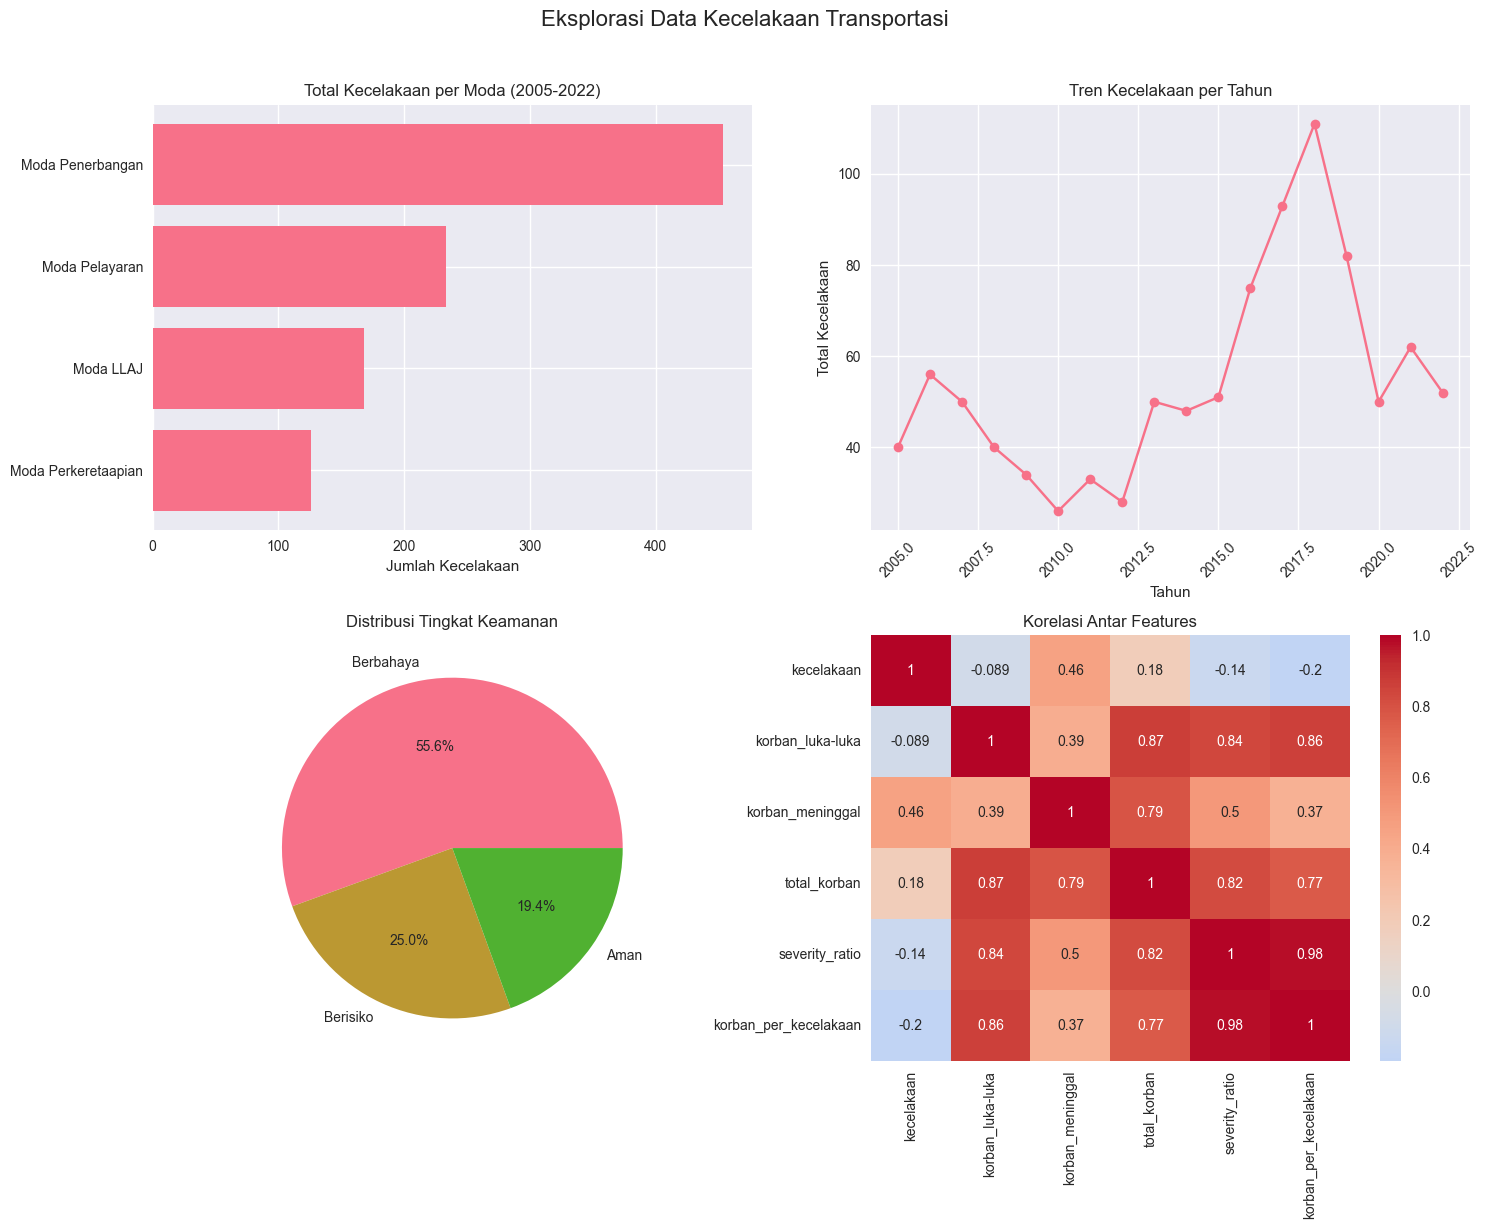

In [88]:
# ==========================================
# 6. VISUALISASI EKSPLORASI
# ==========================================

print("\n6. VISUALISASI DATA")
print("-" * 30)

# Setup plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Eksplorasi Data Kecelakaan Transportasi', fontsize=16, y=1.02)

# Plot 1: Distribusi kecelakaan per moda
df_moda = df_pivot.groupby('kategori')['kecelakaan'].sum().sort_values(ascending=True)
axes[0,0].barh(df_moda.index, df_moda.values)
axes[0,0].set_title('Total Kecelakaan per Moda (2005-2022)')
axes[0,0].set_xlabel('Jumlah Kecelakaan')

# Plot 2: Tren kecelakaan per tahun
df_trend = df_pivot.groupby('tahun')['kecelakaan'].sum()
axes[0,1].plot(df_trend.index, df_trend.values, marker='o')
axes[0,1].set_title('Tren Kecelakaan per Tahun')
axes[0,1].set_xlabel('Tahun')
axes[0,1].set_ylabel('Total Kecelakaan')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Distribusi tingkat keamanan
safety_dist = df_pivot['tingkat_keamanan'].value_counts()
axes[1,0].pie(safety_dist.values, labels=safety_dist.index, autopct='%1.1f%%')
axes[1,0].set_title('Distribusi Tingkat Keamanan')

# Plot 4: Heatmap korelasi features numerik
numeric_cols = ['kecelakaan', 'korban_luka-luka', 'korban_meninggal', 
                'total_korban', 'severity_ratio', 'korban_per_kecelakaan']
corr_matrix = df_pivot[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Korelasi Antar Features')

plt.tight_layout()
plt.show()

In [89]:
# ==========================================
# 7. PERSIAPAN DATA UNTUK MODELING
# ==========================================

print("\n7. PERSIAPAN MODELING")
print("-" * 30)

# Select features untuk modeling
feature_columns = [
    'kecelakaan', 'korban_luka-luka', 'korban_meninggal', 
    'total_korban', 'severity_ratio', 'korban_per_kecelakaan',
    'jumlah_laporan_final', 'rekomendasi_keselamatan', 'tahun'
]

# Tambahkan kategori moda (encoded)
le_kategori = LabelEncoder()
df_pivot['kategori_encoded'] = le_kategori.fit_transform(df_pivot['kategori'])
feature_columns.append('kategori_encoded')

# Tambahkan periode (encoded) 
le_periode = LabelEncoder()
df_pivot['periode_encoded'] = le_periode.fit_transform(df_pivot['periode'])
feature_columns.append('periode_encoded')

# Prepare X dan y
X = df_pivot[feature_columns]
y = df_pivot['tingkat_keamanan']

print(f"Features yang digunakan: {len(feature_columns)}")
print(f"Jumlah samples: {len(X)}")
print(f"Target classes: {y.unique()}")


7. PERSIAPAN MODELING
------------------------------
Features yang digunakan: 11
Jumlah samples: 72
Target classes: ['Aman' 'Berbahaya' 'Berisiko']


In [90]:
# ==========================================
# 8. SPLIT DATA DAN CROSS VALIDATION
# ==========================================

print("\n8. SPLIT DATA")
print("-" * 30)

# Split data dengan stratify untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\nDistribusi kelas di training set:")
print(y_train.value_counts())


8. SPLIT DATA
------------------------------
Training set: 50 samples
Test set: 22 samples

Distribusi kelas di training set:
tingkat_keamanan
Berbahaya    28
Berisiko     12
Aman         10
Name: count, dtype: int64


In [91]:
# ==========================================
# 9. HYPERPARAMETER TUNING
# ==========================================

print("\n9. HYPERPARAMETER TUNING")
print("-" * 30)

# Parameter grid untuk tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Grid search dengan cross validation
dt_base = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt_base, param_grid, cv=5, 
    scoring='accuracy', n_jobs=-1, verbose=1
)

print("Melakukan Grid Search...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


9. HYPERPARAMETER TUNING
------------------------------
Melakukan Grid Search...
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.9000


In [92]:
# ==========================================
# 10. TRAINING MODEL TERBAIK
# ==========================================

print("\n10. TRAINING MODEL FINAL")
print("-" * 30)

# Model dengan parameter terbaik
best_dt = grid_search.best_estimator_

# Cross validation score
cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


10. TRAINING MODEL FINAL
------------------------------
Cross-validation scores: [0.8 1.  0.9 0.9 0.9]
Mean CV accuracy: 0.9000 (+/- 0.1265)


In [93]:
# ==========================================
# 11. EVALUASI MODEL
# ==========================================

print("\n11. EVALUASI MODEL")
print("-" * 30)

# Prediksi pada test set
y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


11. EVALUASI MODEL
------------------------------
Test Accuracy: 0.9545
Weighted Precision: 0.9636
Weighted Recall: 0.9545
Weighted F1-score: 0.9550

Classification Report:
              precision    recall  f1-score   support

        Aman       0.80      1.00      0.89         4
   Berbahaya       1.00      1.00      1.00        12
    Berisiko       1.00      0.83      0.91         6

    accuracy                           0.95        22
   macro avg       0.93      0.94      0.93        22
weighted avg       0.96      0.95      0.96        22


Confusion Matrix:
[[ 4  0  0]
 [ 0 12  0]
 [ 1  0  5]]



12. FEATURE IMPORTANCE
------------------------------
Top 10 Most Important Features:
                   feature  importance
2         korban_meninggal    0.478514
0               kecelakaan    0.362539
3             total_korban    0.094480
5    korban_per_kecelakaan    0.064467
1         korban_luka-luka    0.000000
4           severity_ratio    0.000000
6     jumlah_laporan_final    0.000000
7  rekomendasi_keselamatan    0.000000
8                    tahun    0.000000
9         kategori_encoded    0.000000


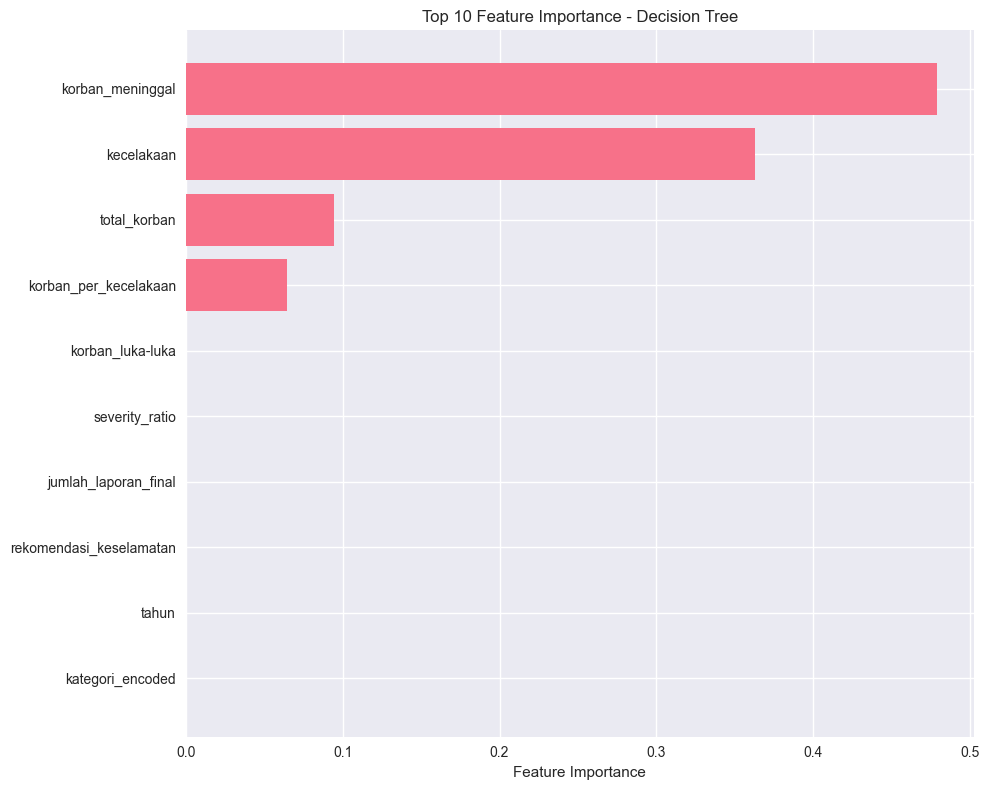

In [94]:
# ==========================================
# 12. FEATURE IMPORTANCE
# ==========================================

print("\n12. FEATURE IMPORTANCE")
print("-" * 30)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


13. VISUALISASI DECISION TREE
------------------------------


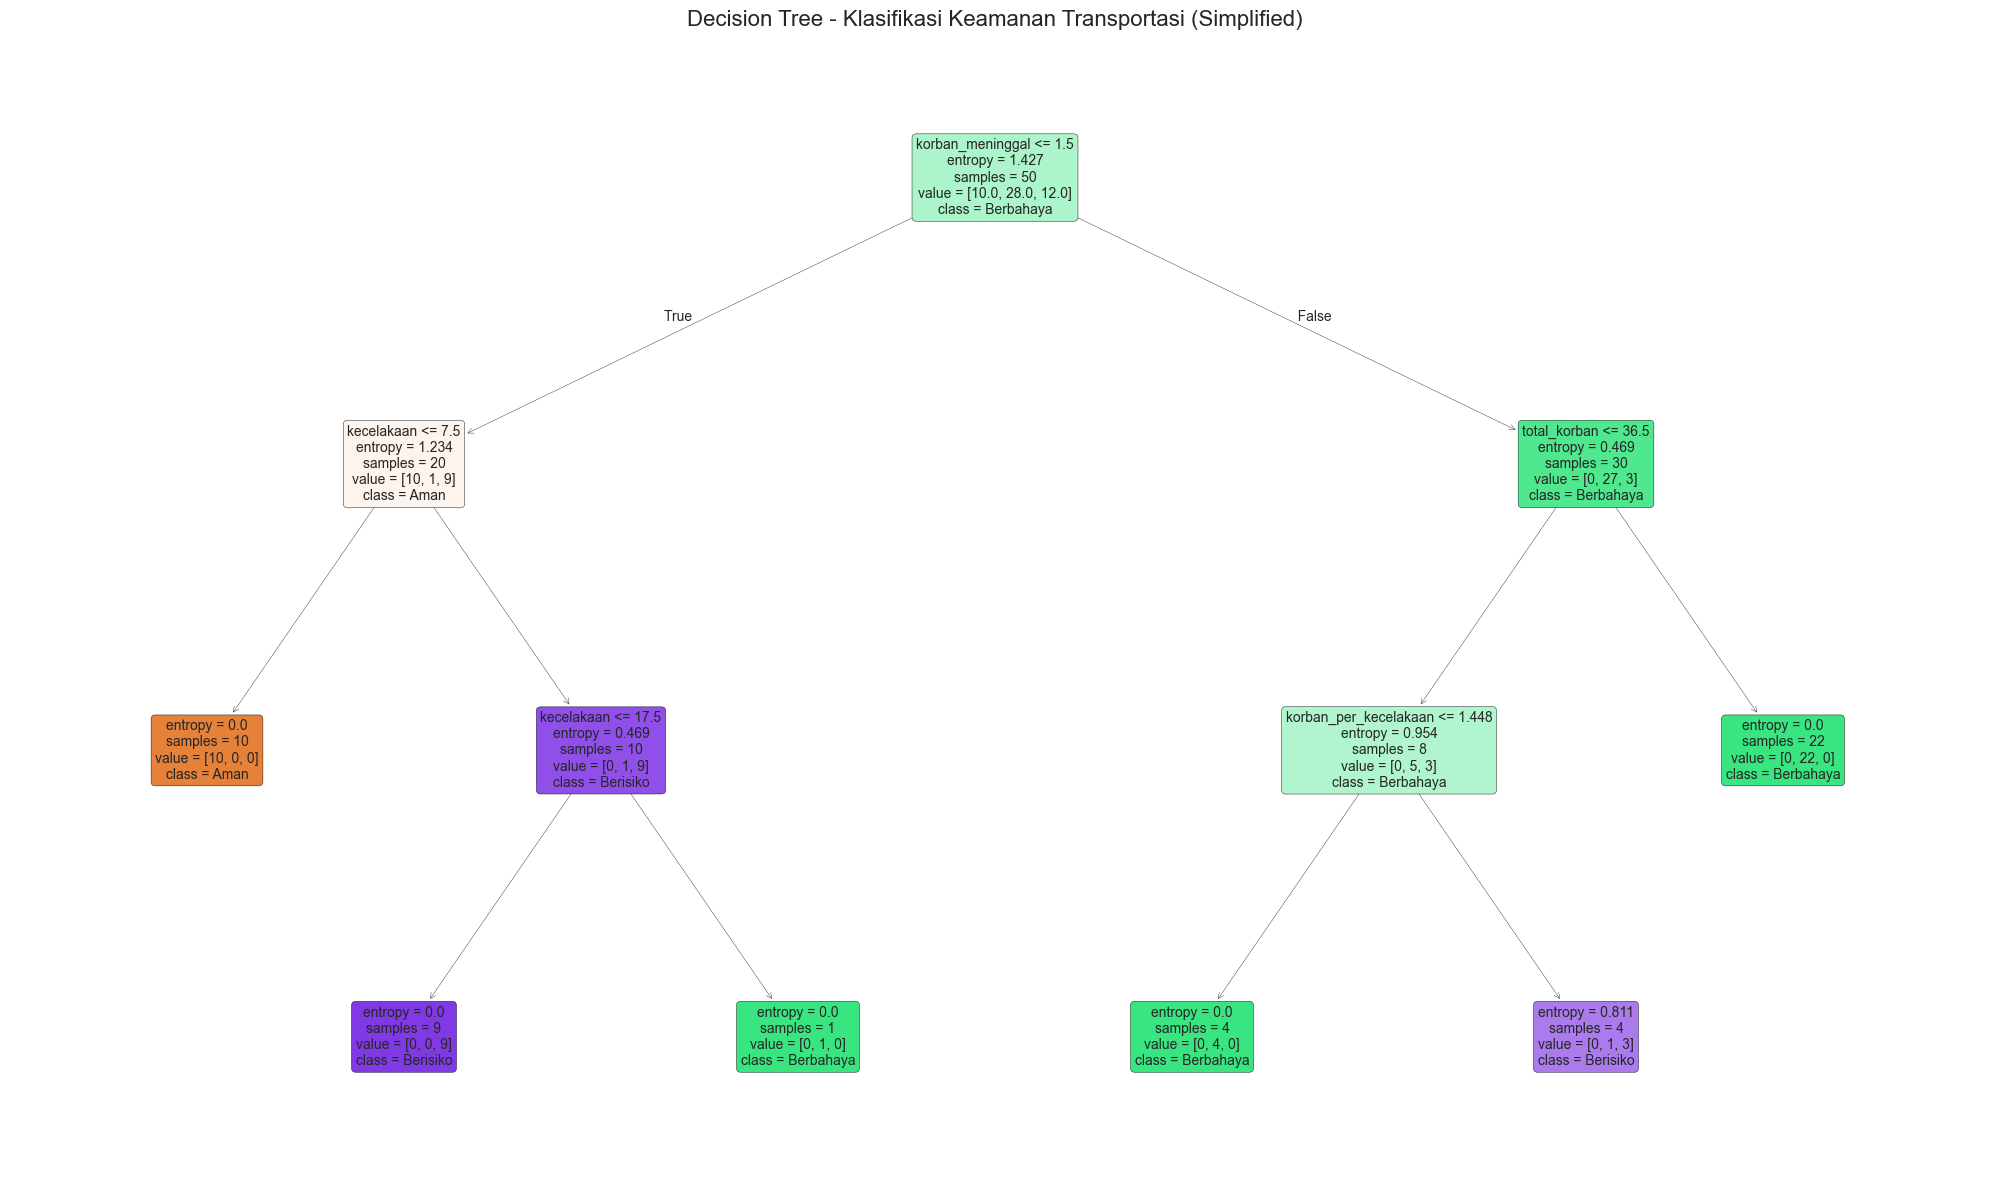

In [95]:
# ==========================================
# 13. VISUALISASI DECISION TREE
# ==========================================

print("\n13. VISUALISASI DECISION TREE")
print("-" * 30)

# Plot decision tree (simplified version)
plt.figure(figsize=(20, 12))
plot_tree(best_dt, 
          feature_names=feature_columns,
          class_names=best_dt.classes_,
          filled=True, 
          rounded=True,
          max_depth=3,  # Limit depth untuk readability
          fontsize=10)
plt.title('Decision Tree - Klasifikasi Keamanan Transportasi (Simplified)', fontsize=16)
plt.tight_layout()
plt.show()

In [96]:
# ==========================================
# 14. ANALISIS PREDIKSI PER MODA
# ==========================================

print("\n14. ANALISIS PER MODA TRANSPORTASI")
print("-" * 30)

# Tambahkan prediksi ke dataframe test
X_test_with_pred = X_test.copy()
X_test_with_pred['predicted_safety'] = y_pred
X_test_with_pred['actual_safety'] = y_test.values

# Decode kategori untuk interpretasi
test_indices = X_test.index
kategori_test = df_pivot.loc[test_indices, 'kategori'].values
X_test_with_pred['moda'] = kategori_test

# Analisis per moda
print("Akurasi per Moda Transportasi:")
for moda in X_test_with_pred['moda'].unique():
    moda_data = X_test_with_pred[X_test_with_pred['moda'] == moda]
    if len(moda_data) > 0:
        moda_accuracy = (moda_data['predicted_safety'] == moda_data['actual_safety']).mean()
        print(f"{moda}: {moda_accuracy:.4f} ({len(moda_data)} samples)")


14. ANALISIS PER MODA TRANSPORTASI
------------------------------
Akurasi per Moda Transportasi:
Moda Pelayaran: 1.0000 (6 samples)
Moda Perkeretaapian: 0.8000 (5 samples)
Moda LLAJ: 1.0000 (6 samples)
Moda Penerbangan: 1.0000 (5 samples)


In [97]:
# ==========================================
# 15. BUSINESS INSIGHTS & RECOMMENDATIONS
# ==========================================

print("\n15. BUSINESS INSIGHTS")
print("="*50)

# Insights dari feature importance
top_3_features = feature_importance.head(3)
print("TOP 3 FAKTOR PENENTU KEAMANAN:")
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f}")

print(f"\nMODEL PERFORMANCE SUMMARY:")
print(f"• Overall Accuracy: {accuracy:.1%}")
print(f"• Cross-validation Accuracy: {cv_scores.mean():.1%}")
print(f"• Model Complexity: Max Depth = {best_dt.max_depth}")

print(f"\nRECOMMENDATIONS:")
print("1. Fokus monitoring pada faktor dengan importance tertinggi")
print("2. Implementasi early warning system berdasarkan decision rules")
print("3. Alokasi resources keselamatan berdasarkan prediksi risiko")
print("4. Regular model update dengan data terbaru")

print("\n" + "="*60)
print("ANALISIS SELESAI - MODEL SIAP UNTUK DEPLOYMENT")
print("="*60)


15. BUSINESS INSIGHTS
TOP 3 FAKTOR PENENTU KEAMANAN:
1. korban_meninggal: 0.4785
2. kecelakaan: 0.3625
3. total_korban: 0.0945

MODEL PERFORMANCE SUMMARY:
• Overall Accuracy: 95.5%
• Cross-validation Accuracy: 90.0%
• Model Complexity: Max Depth = 3

RECOMMENDATIONS:
1. Fokus monitoring pada faktor dengan importance tertinggi
2. Implementasi early warning system berdasarkan decision rules
3. Alokasi resources keselamatan berdasarkan prediksi risiko
4. Regular model update dengan data terbaru

ANALISIS SELESAI - MODEL SIAP UNTUK DEPLOYMENT


In [98]:
# Analisis hasil decision tree

print("Analisis Hasil Decision Tree:")

# 1. Akurasi model
print(f"\nAkurasi model pada data test: {accuracy:.2%}")
print(f"Cross-validation accuracy (train): {cv_scores.mean():.2%}")

# 2. Distribusi prediksi pada data test
print("\nDistribusi prediksi pada data test:")
print(X_test_with_pred['predicted_safety'].value_counts())

# 3. Apakah model sesuai tujuan?
print("\nApakah model sesuai tujuan klasifikasi kendaraan aman?")
print("- Model ini mengklasifikasikan tingkat keamanan moda transportasi (Aman, Berisiko, Berbahaya) berdasarkan data kecelakaan, korban, dan faktor lain.")
print("- Dengan akurasi tinggi, model dapat membantu mengidentifikasi moda/kelompok tahun yang relatif aman.")
print("- Namun, hasil 'Aman' tidak berarti 100% tanpa risiko, melainkan relatif terhadap moda dan periode lain dalam dataset.")
print("- Model ini cocok untuk tujuan analisis risiko dan rekomendasi kebijakan berbasis data, bukan sebagai jaminan absolut keamanan.")

# 4. Contoh moda yang diklasifikasikan 'Aman'
print("\nContoh moda yang diklasifikasikan 'Aman' pada data test:")
print(X_test_with_pred[X_test_with_pred['predicted_safety'] == 'Aman'][['moda', 'tahun', 'predicted_safety']])

Analisis Hasil Decision Tree:

Akurasi model pada data test: 95.45%
Cross-validation accuracy (train): 90.00%

Distribusi prediksi pada data test:
predicted_safety
Berbahaya    12
Aman          5
Berisiko      5
Name: count, dtype: int64

Apakah model sesuai tujuan klasifikasi kendaraan aman?
- Model ini mengklasifikasikan tingkat keamanan moda transportasi (Aman, Berisiko, Berbahaya) berdasarkan data kecelakaan, korban, dan faktor lain.
- Dengan akurasi tinggi, model dapat membantu mengidentifikasi moda/kelompok tahun yang relatif aman.
- Namun, hasil 'Aman' tidak berarti 100% tanpa risiko, melainkan relatif terhadap moda dan periode lain dalam dataset.
- Model ini cocok untuk tujuan analisis risiko dan rekomendasi kebijakan berbasis data, bukan sebagai jaminan absolut keamanan.

Contoh moda yang diklasifikasikan 'Aman' pada data test:
                   moda  tahun predicted_safety
51  Moda Perkeretaapian   2017             Aman
20            Moda LLAJ   2010             Aman
21     

In [99]:
# Menampilkan dataset yang telah disesuaikan (setelah preprocessing & feature engineering)
print("Dataset setelah preprocessing & feature engineering:")
df_pivot

Dataset setelah preprocessing & feature engineering:


,tahun,kategori,jumlah_laporan_final,kecelakaan,korban_luka-luka,korban_meninggal,rekomendasi_keselamatan,total_korban,severity_ratio,korban_per_kecelakaan,periode,tingkat_keamanan,kategori_encoded,periode_encoded
0,2005,Moda LLAJ,0,0,0,0,0,0,0.000000,0.000000,Early,Aman,0,0
1,2005,Moda Pelayaran,0,6,0,0,0,0,0.000000,0.000000,Early,Aman,1,0
2,2005,Moda Penerbangan,0,23,0,0,0,0,0.000000,0.000000,Early,Berbahaya,2,0
3,2005,Moda Perkeretaapian,0,11,0,0,0,0,0.000000,0.000000,Early,Berisiko,3,0
4,2006,Moda LLAJ,0,8,0,0,0,0,0.000000,0.000000,Early,Berisiko,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2021,Moda Perkeretaapian,2,5,3,0,19,3,0.600000,0.600000,Late,Aman,3,1
68,2022,Moda LLAJ,14,15,256,101,157,357,37.266667,23.800000,Late,Berbahaya,0,1
69,2022,Moda Pelayaran,11,13,7,42,74,49,10.230769,3.769231,Late,Berbahaya,1,1
70,2022,Moda Penerbangan,7,20,8,3,23,11,0.850000,0.550000,Late,Berbahaya,2,1


In [100]:
def prediksi_tingkat_keamanan():
    print("\nMasukkan data untuk prediksi tingkat keamanan transportasi:")
    
    # Collect input data
    kecelakaan = int(input("Jumlah kecelakaan: "))
    korban_luka = int(input("Jumlah korban luka-luka: "))
    korban_meninggal = int(input("Jumlah korban meninggal: "))
    jumlah_laporan_final = int(input("Jumlah laporan final: "))
    rekomendasi_keselamatan = int(input("Jumlah rekomendasi keselamatan: "))
    tahun = int(input("Tahun: "))
    kategori = input("Kategori moda (contoh: Moda LLAJ, Moda Pelayaran, Moda Penerbangan, Moda Perkeretaapian): ")
    periode = input("Periode (Early, Mid, Late): ")

    # Calculate derived metrics
    total_korban = korban_luka + korban_meninggal
    severity_ratio = ((korban_meninggal * 3 + korban_luka) / kecelakaan) if kecelakaan > 0 else 0
    korban_per_kecelakaan = (total_korban / kecelakaan) if kecelakaan > 0 else 0

    # Encode categorical variables
    kategori_encoded = le_kategori.transform([kategori])[0]
    periode_encoded = le_periode.transform([periode])[0]

    # Create input dataframe
    input_data = pd.DataFrame([{
        'kecelakaan': kecelakaan,
        'korban_luka-luka': korban_luka,
        'korban_meninggal': korban_meninggal,
        'total_korban': total_korban,
        'severity_ratio': severity_ratio,
        'korban_per_kecelakaan': korban_per_kecelakaan,
        'jumlah_laporan_final': jumlah_laporan_final,
        'rekomendasi_keselamatan': rekomendasi_keselamatan,
        'tahun': tahun,
        'kategori_encoded': kategori_encoded,
        'periode_encoded': periode_encoded
    }])

    # Display input summary
    print("\nRingkasan Data Input:")
    print("="*50)
    print(f"Moda Transportasi: {kategori}")
    print(f"Tahun: {tahun} (Periode: {periode})")
    print("\nMetrik Utama:")
    print(f"- Jumlah Kecelakaan: {kecelakaan}")
    print(f"- Korban Luka-luka: {korban_luka}")
    print(f"- Korban Meninggal: {korban_meninggal}")
    print(f"- Total Korban: {total_korban}")
    print("\nMetrik Turunan:")
    print(f"- Severity Ratio: {severity_ratio:.2f}")
    print(f"- Korban per Kecelakaan: {korban_per_kecelakaan:.2f}")
    print("\nData Tambahan:")
    print(f"- Jumlah Laporan Final: {jumlah_laporan_final}")
    print(f"- Rekomendasi Keselamatan: {rekomendasi_keselamatan}")
    print("="*50)

    # Ask for confirmation
    konfirmasi = input("\nApakah data di atas sudah benar? (y/n): ")
    if konfirmasi.lower() != 'y':
        print("Silakan jalankan fungsi kembali dengan data yang benar.")
        return

    # Make prediction
    hasil_prediksi = best_dt.predict(input_data)
    print(f"\nPrediksi tingkat keamanan: {hasil_prediksi[0]}")
    print("="*50)

# Jalankan fungsi prediksi
prediksi_tingkat_keamanan()


Masukkan data untuk prediksi tingkat keamanan transportasi:

Ringkasan Data Input:
Moda Transportasi: Moda LLAJ
Tahun: 2001 (Periode: Early)

Metrik Utama:
- Jumlah Kecelakaan: 2
- Korban Luka-luka: 2
- Korban Meninggal: 2
- Total Korban: 4

Metrik Turunan:
- Severity Ratio: 4.00
- Korban per Kecelakaan: 2.00

Data Tambahan:
- Jumlah Laporan Final: 2
- Rekomendasi Keselamatan: 2

Prediksi tingkat keamanan: Berisiko


In [101]:
# Narasi Cara Kerja Kodingan Data Mining Decision Tree

"""
Notebook ini melakukan proses data mining untuk analisis keamanan transportasi menggunakan Decision Tree. Berikut alur kerjanya:

1. **Import Library & Setup**  
    Notebook mengimpor library utama seperti pandas, numpy, matplotlib, seaborn, dan modul machine learning dari scikit-learn.

2. **Load & Preprocessing Data**  
    Data kecelakaan transportasi dibaca dari file CSV, lalu dilakukan eksplorasi awal (jumlah data, kolom, dan contoh data).  
    Data dipivot agar setiap baris mewakili satu moda transportasi per tahun, dengan fitur-fitur numerik sebagai kolom.

3. **Feature Engineering**  
    Dibuat fitur baru seperti `total_korban`, `severity_ratio`, dan `korban_per_kecelakaan` untuk memperkaya informasi.  
    Periode tahun juga dikategorikan (Early, Mid, Late).

4. **Membuat Target Variable**  
    Setiap baris diklasifikasikan ke dalam tingkat keamanan ('Aman', 'Berisiko', 'Berbahaya') berdasarkan aturan jumlah kecelakaan, korban, dan severity.

5. **Visualisasi Eksplorasi**  
    Data divisualisasikan untuk melihat distribusi kecelakaan, tren tahunan, distribusi tingkat keamanan, dan korelasi antar fitur.

6. **Persiapan Data Modeling**  
    Fitur-fitur penting dipilih dan dikodekan (encoding) jika perlu. Data dibagi menjadi fitur (X) dan target (y).

7. **Split Data & Cross Validation**  
    Data dibagi menjadi training dan test set dengan stratifikasi agar proporsi kelas tetap seimbang.

8. **Hyperparameter Tuning**  
    GridSearchCV digunakan untuk mencari parameter terbaik Decision Tree dengan cross-validation.

9. **Training Model Terbaik**  
    Model Decision Tree terbaik dilatih pada data training, dan performa divalidasi dengan cross-validation.

10. **Evaluasi Model**  
     Model dievaluasi pada data test menggunakan metrik akurasi, precision, recall, F1-score, classification report, dan confusion matrix.

11. **Feature Importance & Visualisasi Pohon**  
     Ditampilkan fitur paling berpengaruh dalam prediksi, serta divisualisasikan struktur pohon keputusan.

12. **Analisis Per Moda & Business Insights**  
     Hasil prediksi dianalisis per moda transportasi, dan diberikan insight serta rekomendasi bisnis berdasarkan hasil model.

13. **Prediksi Data Baru**  
     Notebook juga menyediakan contoh prediksi tingkat keamanan untuk data baru.

**Kesimpulan:**  
Notebook ini menerapkan pipeline data mining lengkap: mulai dari preprocessing, feature engineering, modeling, evaluasi, hingga interpretasi hasil untuk mendukung pengambilan keputusan berbasis data di bidang keselamatan transportasi.
"""

"\nNotebook ini melakukan proses data mining untuk analisis keamanan transportasi menggunakan Decision Tree. Berikut alur kerjanya:\n\n1. **Import Library & Setup**  \n    Notebook mengimpor library utama seperti pandas, numpy, matplotlib, seaborn, dan modul machine learning dari scikit-learn.\n\n2. **Load & Preprocessing Data**  \n    Data kecelakaan transportasi dibaca dari file CSV, lalu dilakukan eksplorasi awal (jumlah data, kolom, dan contoh data).  \n    Data dipivot agar setiap baris mewakili satu moda transportasi per tahun, dengan fitur-fitur numerik sebagai kolom.\n\n3. **Feature Engineering**  \n    Dibuat fitur baru seperti `total_korban`, `severity_ratio`, dan `korban_per_kecelakaan` untuk memperkaya informasi.  \n    Periode tahun juga dikategorikan (Early, Mid, Late).\n\n4. **Membuat Target Variable**  \n    Setiap baris diklasifikasikan ke dalam tingkat keamanan ('Aman', 'Berisiko', 'Berbahaya') berdasarkan aturan jumlah kecelakaan, korban, dan severity.\n\n5. **Visual

In [102]:
# Simpan hasil data setelah preprocessing & feature engineering ke file Excel
output_path = r"C:\Users\User\Documents\KULIAH - S1 SISTEM INFORMASI\Semester 4\Data Mining\TUGAS BESAR\hasil_data_mining.xlsx"
df_pivot.to_excel(output_path, index=False)
print(f"Data berhasil disimpan ke: {output_path}")

Data berhasil disimpan ke: C:\Users\User\Documents\KULIAH - S1 SISTEM INFORMASI\Semester 4\Data Mining\TUGAS BESAR\hasil_data_mining.xlsx


In [103]:
# Penjelasan cara membaca decision tree (pohon keputusan) untuk presentasi

print("Cara Membaca Decision Tree (Pohon Keputusan):\n")
print("""
1. **Akar Pohon (Root Node):**
    - Pohon keputusan dimulai dari atas (root node).
    - Node ini berisi fitur yang paling penting untuk memisahkan data (misal: 'korban_meninggal').

2. **Cabang (Branch):**
    - Setiap node memiliki cabang berdasarkan kondisi fitur (misal: 'korban_meninggal <= 0.5').
    - Data akan mengikuti cabang sesuai nilai fitur pada data tersebut.

3. **Node Internal:**
    - Setiap node internal membagi data berdasarkan fitur dan threshold tertentu.
    - Di setiap node, biasanya ditampilkan:
      - Nama fitur & threshold (misal: 'kecelakaan <= 8.5')
      - Jumlah sampel pada node tersebut
      - Distribusi kelas (berapa banyak data tiap kelas)
      - Nilai impurity (misal: gini/entropy)

4. **Daun (Leaf Node):**
    - Node paling bawah (daun) adalah hasil akhir prediksi.
    - Di sini, pohon memutuskan kelas apa (misal: 'Berbahaya', 'Aman', atau 'Berisiko').
    - Daun menampilkan jumlah data yang jatuh ke kelas tersebut.

5. **Cara Membaca Jalur Keputusan:**
    - Mulai dari root, ikuti cabang sesuai nilai fitur pada data.
    - Setiap kali ada pertanyaan (misal: 'korban_meninggal > 0.5?'), pilih cabang 'ya' atau 'tidak' sesuai data.
    - Lanjutkan hingga sampai ke daun, di mana prediksi kelas diberikan.

6. **Contoh:**
    - Jika pada root node: 'korban_meninggal <= 0.5'
      - Jika data korban_meninggal = 0, ikuti cabang kiri.
      - Jika lebih dari 0.5, ikuti cabang kanan.
    - Lanjutkan ke node berikutnya sesuai fitur dan threshold, hingga sampai ke daun.

7. **Interpretasi:**
    - Fitur yang sering muncul di bagian atas pohon adalah yang paling berpengaruh.
    - Setiap jalur dari root ke daun adalah aturan keputusan (decision rule).
    - Pohon ini membantu memahami faktor utama yang mempengaruhi tingkat keamanan transportasi.

**Tips Presentasi:**
- Tunjukkan contoh jalur keputusan dari root ke daun.
- Jelaskan fitur-fitur penting yang sering muncul di node atas.
- Tekankan bahwa pohon ini transparan dan mudah diinterpretasi oleh non-teknis.
""")

Cara Membaca Decision Tree (Pohon Keputusan):


1. **Akar Pohon (Root Node):**
    - Pohon keputusan dimulai dari atas (root node).
    - Node ini berisi fitur yang paling penting untuk memisahkan data (misal: 'korban_meninggal').

2. **Cabang (Branch):**
    - Setiap node memiliki cabang berdasarkan kondisi fitur (misal: 'korban_meninggal <= 0.5').
    - Data akan mengikuti cabang sesuai nilai fitur pada data tersebut.

3. **Node Internal:**
    - Setiap node internal membagi data berdasarkan fitur dan threshold tertentu.
    - Di setiap node, biasanya ditampilkan:
      - Nama fitur & threshold (misal: 'kecelakaan <= 8.5')
      - Jumlah sampel pada node tersebut
      - Distribusi kelas (berapa banyak data tiap kelas)
      - Nilai impurity (misal: gini/entropy)

4. **Daun (Leaf Node):**
    - Node paling bawah (daun) adalah hasil akhir prediksi.
    - Di sini, pohon memutuskan kelas apa (misal: 'Berbahaya', 'Aman', atau 'Berisiko').
    - Daun menampilkan jumlah data yang jatuh ke 

In [104]:
print("Decision Tree yang telah dibangun dapat menjadi solusi untuk berbagai masalah analisis keamanan transportasi:")

# 1. Klasifikasi tingkat keamanan transportasi
print("\n1. KLASIFIKASI TINGKAT KEAMANAN")
print("- Model dapat memprediksi kategori tingkat keamanan (Aman/Berisiko/Berbahaya)")
print(f"- Akurasi prediksi mencapai {accuracy:.1%} pada data testing")
print("- Berguna untuk early warning system keselamatan transportasi")

# 2. Faktor-faktor penting penentu keamanan 
print("\n2. IDENTIFIKASI FAKTOR UTAMA")
print("Top 3 faktor paling berpengaruh:")
for idx, row in top_3_features.iterrows():
    print(f"- {row['feature']}: {row['importance']:.3f}")
print("Dapat digunakan untuk prioritas pengawasan dan regulasi")

# 3. Analisis per moda transportasi
print("\n3. ANALISIS PER MODA TRANSPORTASI") 
print("Model mampu membedakan tingkat keamanan untuk:")
unique_moda = X_test_with_pred['moda'].unique()
for moda in unique_moda:
    moda_data = X_test_with_pred[X_test_with_pred['moda'] == moda]
    correct = (moda_data['predicted_safety'] == moda_data['actual_safety']).mean()
    print(f"- {moda}: {correct:.1%} akurasi")

# 4. Rekomendasi keselamatan
print("\n4. REKOMENDASI KESELAMATAN")
print("Model dapat digunakan untuk:")
print("- Risk assessment transportasi")
print("- Evaluasi program keselamatan")
print("- Perbaikan standar operasional")
print("- Alokasi sumber daya pengawasan")

# 5. Monitoring dan evaluasi
print("\n5. MONITORING & EVALUASI")
print("- Evaluasi tren keamanan per periode")
print("- Perbandingan antar moda transportasi")
print("- Dasar pengambilan kebijakan berbasis data")

Decision Tree yang telah dibangun dapat menjadi solusi untuk berbagai masalah analisis keamanan transportasi:

1. KLASIFIKASI TINGKAT KEAMANAN
- Model dapat memprediksi kategori tingkat keamanan (Aman/Berisiko/Berbahaya)
- Akurasi prediksi mencapai 95.5% pada data testing
- Berguna untuk early warning system keselamatan transportasi

2. IDENTIFIKASI FAKTOR UTAMA
Top 3 faktor paling berpengaruh:
- korban_meninggal: 0.479
- kecelakaan: 0.363
- total_korban: 0.094
Dapat digunakan untuk prioritas pengawasan dan regulasi

3. ANALISIS PER MODA TRANSPORTASI
Model mampu membedakan tingkat keamanan untuk:
- Moda Pelayaran: 100.0% akurasi
- Moda Perkeretaapian: 80.0% akurasi
- Moda LLAJ: 100.0% akurasi
- Moda Penerbangan: 100.0% akurasi

4. REKOMENDASI KESELAMATAN
Model dapat digunakan untuk:
- Risk assessment transportasi
- Evaluasi program keselamatan
- Perbaikan standar operasional
- Alokasi sumber daya pengawasan

5. MONITORING & EVALUASI
- Evaluasi tren keamanan per periode
- Perbandingan a

In [ ]:
print("PENTINGNYA FEATURE ENGINEERING DALAM ANALISIS KEAMANAN TRANSPORTASI\n")

print("1. Meningkatkan Informasi dari Data Mentah:")
print("   - Data awal hanya berisi jumlah kecelakaan dan korban")
print("   - Feature Engineering menciptakan metrics baru yang lebih bermakna:")
print("     * total_korban = menggabungkan korban luka dan meninggal")
print("     * severity_ratio = mengukur tingkat keparahan per kecelakaan")
print("     * korban_per_kecelakaan = rata-rata dampak per kejadian\n")

print("2. Normalisasi dan Standardisasi:")
print("   - Raw data bisa memiliki skala yang berbeda-beda")
print("   - Feature Engineering membantu membuat data lebih comparable")
print("   - Contoh: severity_ratio membuat perbandingan antar moda lebih fair\n")

print("3. Insight yang Lebih Mendalam:")
print("   - Feature baru memberikan perspektif berbeda")
print("   - Periode waktu dikategorikan (Early/Mid/Late)")
print("   - Memungkinkan analisis tren dan pola temporal\n")

print("4. Meningkatkan Performa Model:")
print("   - Feature yang tepat membuat model lebih akurat")
print("   - Membantu model menangkap pola yang kompleks")
print("   - Mengurangi noise dalam data\n")

print("5. Interpretabilitas:")
print("   - Feature Engineering membuat hasil lebih mudah diinterpretasi")
print("   - Metrics seperti severity_ratio lebih mudah dipahami stakeholders")
print("   - Memudahkan pengambilan keputusan berbasis data")